# Brain Tumor Classification (CMPS 261 - Spring 2025)

This notebook trains a deep learning model to classify brain MRI scans as either containing a tumor or not. 
The dataset contains `.jpg` images and `.txt` labels. This project focuses on the classification aspect.

## Workflow:
1. Load and clean dataset
2. Build TensorFlow data pipeline
3. Build and train CNN model
4. Evaluate and save model


## 1. Dataset Preparation

We load and organize the dataset, which consists of brain MRI images and associated label files.
Each label indicates the presence of a tumor (1) or not (0), along with bounding box data — which we ignore for negative samples, per instructor instructions.

### Loading & Understanding our Data:

In [46]:
import os

# Defining paths to image and label folders respectively:
image_dir = './data/images/'
label_dir = './data/labels/'

# Count # of image files
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
num_images = len(image_files)

print(f"Total number of images: {num_images}")

# Count # of text files
image_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
num_labels = len(image_files)

print(f"Total number of labels: {num_labels}")

# Check how many images are missing labels
print(f'There are {num_images - num_labels} images missing a label!')

Total number of images: 893
Total number of labels: 878
There are 15 images missing a label!


### Before proceeding this is a basic example of how we can use the label + BBOX info to display the tumor:

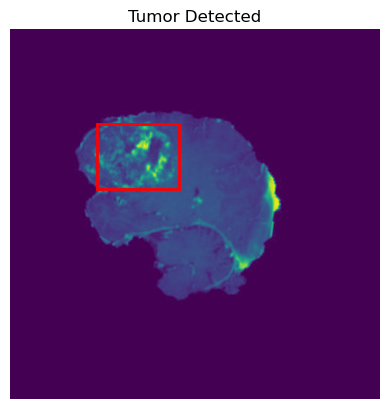

In [47]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# === Step 1: Load the image ===
image_path = image_dir + '00054_145.jpg'
label_path = label_dir + '00054_145.txt'

image = Image.open(image_path)
img_width, img_height = image.size

# === Step 2: Read the label ===
with open(label_path, 'r') as f:
    line = f.readline().strip()
    parts = line.split()
    label = int(parts[0])
    x_center = float(parts[1])
    y_center = float(parts[2])
    width = float(parts[3])
    height = float(parts[4])

# === Step 3: Convert normalized values to pixels ===
x_center_pixel = x_center * img_width
y_center_pixel = y_center * img_height
box_width_pixel = width * img_width
box_height_pixel = height * img_height

# Convert from center to top-left corner
x_min = x_center_pixel - (box_width_pixel / 2)
y_min = y_center_pixel - (box_height_pixel / 2)

# === Step 4: Plot image and box ===
fig, ax = plt.subplots(1)
ax.imshow(image)

# Only draw the box if there's a tumor
if label == 1:
    rect = patches.Rectangle(
        (x_min, y_min),
        box_width_pixel,
        box_height_pixel,
        linewidth=2,
        edgecolor='r',
        facecolor='none'
    )
    ax.add_patch(rect)
    plt.title("Tumor Detected")
else:
    plt.title("No Tumor")

plt.axis('off')
plt.show()

### Okay, now that we understand how the data can be used let's find how many usable pairs we have:

In [48]:
# Helper: get filenames without extension
image_files = set(f[:-4] for f in os.listdir(image_dir) if f.endswith('.jpg'))
label_files = set(f[:-4] for f in os.listdir(label_dir) if f.endswith('.txt'))

# Intersection → only matched pairs
valid_ids = sorted(image_files & label_files)
print(f"Total valid image-label pairs: {len(valid_ids)}")

# Final dataset list
dataset = []

for img_id in valid_ids:
    label_path = os.path.join(label_dir, img_id + '.txt')
    image_path = os.path.join(image_dir, img_id + '.jpg')
    
    with open(label_path, 'r') as f:
        parts = f.readline().strip().split()
        label = int(parts[0])

        if label == 0:
            # No tumor: ignore bbox
            dataset.append((image_path, label, None))
        else:
            # Tumor: include bbox
            bbox = list(map(float, parts[1:]))
            dataset.append((image_path, label, bbox))

print(f"Prepared dataset with {len(dataset)} usable samples")

Total valid image-label pairs: 878
Prepared dataset with 878 usable samples


## 2. Data Pipeline with `tf.data`

Now that we've bundled our pairs we can create a TensorFlow data pipeline to efficiently load, process, and batch images for training.
This includes:
- Reading image files
- Resizing and normalizing
- Batching and prefetching for performance

### We start by defining general settings and image processing:

In [49]:
import tensorflow as tf

tf.random.set_seed(1)

# === General Settings ===
IMG_SIZE = (224, 224)       # Target image dimensions (height, width)
BATCH_SIZE = 32             # Number of samples per training batch

# === Step 1: Image Preprocessing Function ===
def load_and_preprocess(image_path, label, bbox):
    """Load, decode, and preprocess an image and its label.
    Args:
        image_path: Path to the image file (tf.string).
        label: Class label (0 = no tumor, 1 = tumor).
        bbox: Bounding box coordinates (ignored in this function).
    Returns:
        Tuple of (normalized image tensor, label).
    """
    # Read and decode the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Ensure RGB format
    image = tf.image.resize(image, IMG_SIZE)         # Resize to target dimensions
    image = tf.cast(image, tf.float32) / 255.0       # Normalize pixel values to [0, 1]
    return image, label # I'm ignoring bbox for now!

### Now we define a reusable function that creates datasets from a list of image-label-bbox tuples:

In [50]:
# === Step 2: Creating Generalized Dataset Generator ===
def create_dataset(data_list, repeat=True, shuffle=True):
    """
    Creates a tf.data.Dataset from a list of (image_path, label, bbox) tuples.

    Args:
        data_list (list): List of (image_path, label, bbox) tuples.
        repeat (bool): Whether to repeat the dataset (default: True).
        shuffle (bool): Whether to shuffle the dataset (default: True).

    Returns:
        tf.data.Dataset: A prepared dataset ready for training or evaluation.
    """
    def generator():
        for image_path, label, bbox in data_list:
            # For negative samples (label == 0), supply a dummy bbox
            if bbox is None:
                bbox = [0.0, 0.0, 0.0, 0.0]
            yield image_path.encode(), label, bbox  # Encode path as bytes for TensorFlow

    # Define the output signature (same for all datasets)
    output_signature = (
        tf.TensorSpec(shape=(), dtype=tf.string),   # image_path (scalar string)
        tf.TensorSpec(shape=(), dtype=tf.int32),    # label (scalar integer)
        tf.TensorSpec(shape=(4,), dtype=tf.float32) # bbox (4 float values: x_center, y_center, width, height)
    )

    ds = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
    ds = ds.map(load_and_preprocess)

    if shuffle:
        ds = ds.shuffle(1000)  # Shuffle with buffer size of 1000
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # Optimize loading + training overlap
    if repeat:
        ds = ds.repeat()  # Repeat for multiple epochs (if training)

    return ds

### Finally we create our first dataset: base_dataset

In [51]:
# Create a dataset using the new create_dataset() function
base_dataset = create_dataset(dataset)
print("✅ base_dataset created successfully.")

✅ base_dataset created successfully.


### Quick test to ensure the dataset yields and displays samples correctly:

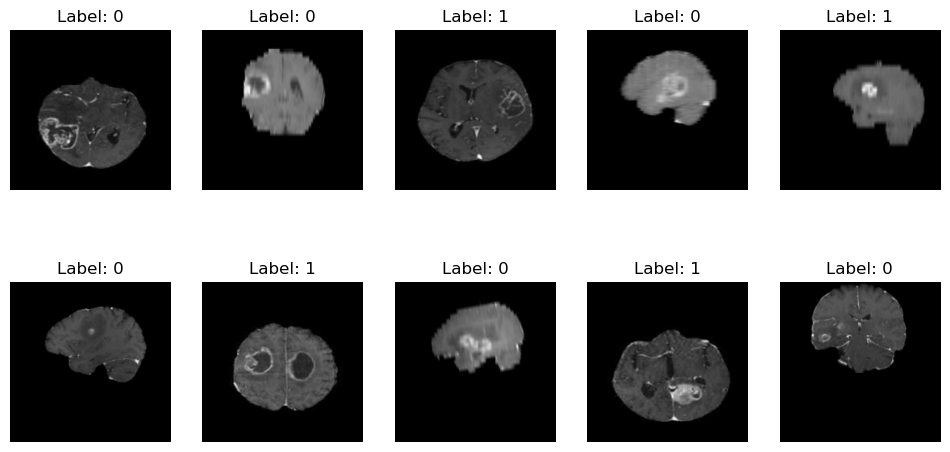

✅ Dataset pipeline functional.


In [52]:
for images, labels in base_dataset.take(1):
    plt.figure(figsize=(12, 6))
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()
print("✅ Dataset pipeline functional.")

## 3. Model Architecture (Transfer Learning)

We use MobileNetV2 as a pretrained CNN backbone, removing its top classification layers.
A custom head is added for binary classification (tumor vs. no tumor), using:
- Global average pooling
- Dense layers
- Dropout for regularization

### Load pretrained model:

In [53]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# === Load Pretrained MobileNetV2 (without top classifier) ===
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,       # Exclude the original classification head
    weights='imagenet'       # Load pretrained weights from ImageNet
)
base_model.trainable = False  # Freeze the base

# === Add Custom Classification Head ===
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),           # Reduce feature maps to a vector
    layers.Dense(128, activation='relu'),      # Optional fully connected layer
    layers.Dropout(0.3),                       # Regularization
    layers.Dense(1, activation='sigmoid')      # Output layer for binary classification
])

### Compile Model:

In [54]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [55]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Train Model:

We train the model on the preprocessed dataset using 10 epochs.
The dataset is repeated to support multiple epochs, and steps per epoch are calculated based on batch size.

In [56]:
EPOCHS = 10
steps_per_epoch = len(dataset) // BATCH_SIZE

history = model.fit(
    base_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch
)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 312ms/step - accuracy: 0.5096 - loss: 0.8580
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 321ms/step - accuracy: 0.6382 - loss: 0.6345
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 314ms/step - accuracy: 0.7017 - loss: 0.5708
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 303ms/step - accuracy: 0.7064 - loss: 0.5773
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 303ms/step - accuracy: 0.7259 - loss: 0.5567
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 306ms/step - accuracy: 0.7164 - loss: 0.5212
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 305ms/step - accuracy: 0.7802 - loss: 0.4644
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 306ms/step - accuracy: 0.7880 - loss: 0.4490
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 304ms/step - accuracy: 0.8079 - loss: 0.4374
Epoch 10/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 310ms/step - accuracy: 0.8527 - loss: 0.3588


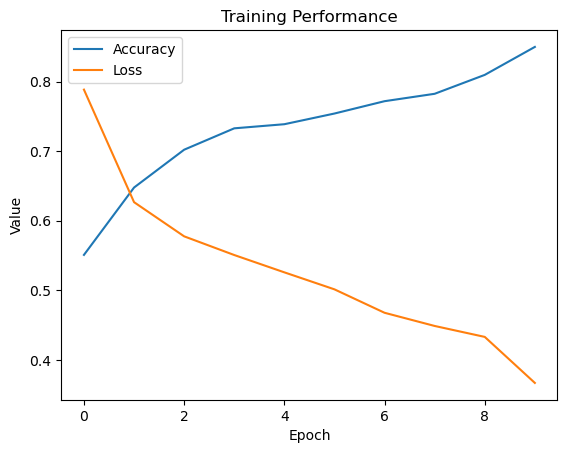

In [57]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Training Performance')
plt.show()

## 4. Model Evaluation & Saving

We evaluate model performance on a held-out 20% validation set using accuracy and loss metrics.
This helps confirm generalization and detect overfitting.


In [58]:
from sklearn.model_selection import train_test_split

# Split the original list of tuples (image_path, label, bbox)
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=1)

print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")

Train size: 702
Validation size: 176


In [ ]:
# After splitting the data into train_data and val_data

# We use the already defined create_dataset function to create a train_dataset.
train_dataset = create_dataset(train_data)
print("✅ train_dataset created successfully.")

# Proceed to model training
steps_per_epoch = len(train_data) // BATCH_SIZE
model.fit(train_dataset, epochs=10, steps_per_epoch=steps_per_epoch)

✅ train_dataset created successfully.
Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 332ms/step - accuracy: 0.8464 - loss: 0.3583
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 358ms/step - accuracy: 0.8451 - loss: 0.3564
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 362ms/step - accuracy: 0.8832 - loss: 0.3212
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 332ms/step - accuracy: 0.8966 - loss: 0.2912
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 343ms/step - accuracy: 0.8554 - loss: 0.3216
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 347ms/step - accuracy: 0.8851 - loss: 0.3116
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 336ms/step - accuracy: 0.8785 - loss: 0.2808
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 324ms/step - accuracy: 0.9182 - loss: 0.2482
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 320ms/step - accuracy: 0.9375 - loss: 0.2309
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 317ms/step - accuracy: 0.9145 - loss: 0.2104


In [ ]:
# Same thing we use create_dataset to create the validation set.
val_dataset = create_dataset(val_data, repeat=False, shuffle=False)
print("✅ val_dataset pipeline ready.")

✅ val_dataset pipeline ready.


In [ ]:
# Evaluating based on accuracy
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 301ms/step - accuracy: 0.8988 - loss: 0.2950
Validation Accuracy: 0.8977
Validation Loss: 0.3038


### Save the Trained Model

The model is saved as a `.keras` file, preserving both the architecture and weights.
This allows future reuse for inference or deployment.

In [62]:
model.save("brain_tumor_model.keras")

## 5. Predict Tumor Presence on Sample MRI Images

We randomly select images from the validation set and display the model's predictions.
This serves as a qualitative check of model performance.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


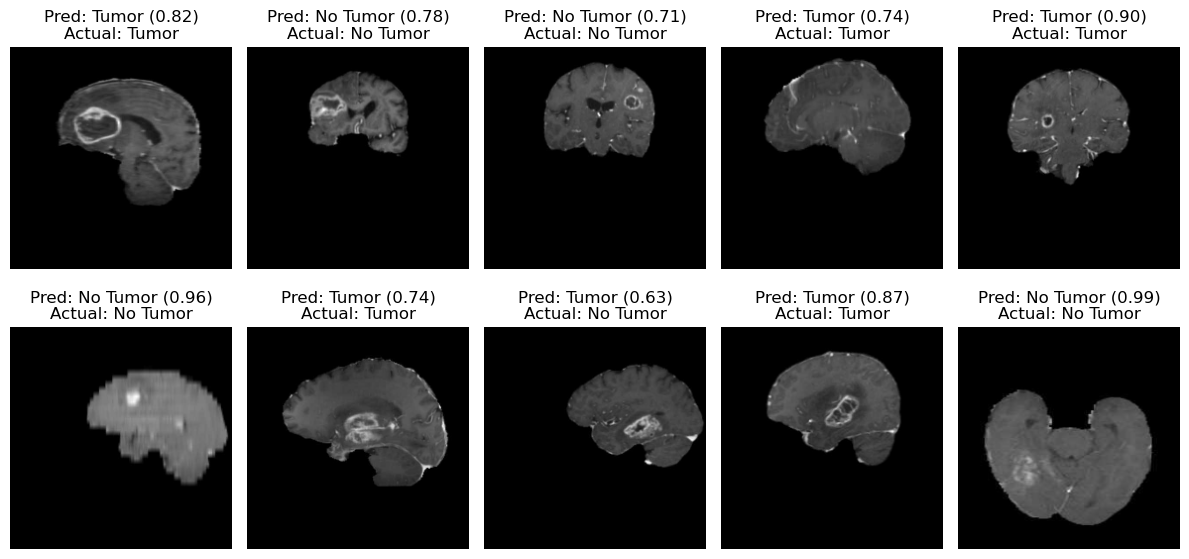

In [63]:
import random

# Choose 10 random samples from validation data
sample_images = random.sample(val_data, 10)

plt.figure(figsize=(12, 6))

for i, (image_path, true_label, bbox) in enumerate(sample_images):
    # Load and preprocess image
    image_raw = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_raw, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.expand_dims(image, 0)  # Batch dimension

    # Predict
    pred = model.predict(image)[0][0]
    pred_label = "Tumor" if pred >= 0.5 else "No Tumor"
    confidence = pred if pred >= 0.5 else 1 - pred

    # Ground truth
    actual_label = "Tumor" if true_label == 1 else "No Tumor"

    # Plot
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(tf.squeeze(image))
    plt.title(f"Pred: {pred_label} ({confidence:.2f})\nActual: {actual_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()
